In [ ]:
!pip install category_encoders

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 85.7/85.7 kB 8.3 MB/s eta 0:00:00


In [ ]:
# ===========================
# Step 1: Load Dataset
# ===========================
from google.colab import drive
drive.mount('/content/drive')

import pandas as pd
import numpy as np
from sklearn.impute import KNNImputer
from category_encoders import TargetEncoder

# File path
file_path = '/content/drive/My Drive/datasets/healthcare-dataset-stroke-data.csv'
data = pd.read_csv(file_path)

print("Full dataset shape:", data.shape)

Mounted at /content/drive
Full dataset shape: (5110, 12)


In [ ]:
# Drop unwanted columns
cols_to_drop = ['Patient ID']
data.drop(columns=[col for col in cols_to_drop if col in data.columns], inplace=True)

# Identify numerical & categorical columns
num_cols = data.select_dtypes(include=[np.number]).columns.tolist()
cat_cols = data.select_dtypes(include=['object']).columns.tolist()


In [ ]:
# Numerical imputation
num_imputer = KNNImputer(n_neighbors=5)
data[num_cols] = num_imputer.fit_transform(data[num_cols])

# Categorical imputation
for col in cat_cols:
    if col.lower() == 'symptoms':
        data[col] = data[col].fillna('no symptoms')
    else:
        data[col] = data[col].fillna(data[col].mode()[0])


In [ ]:
# Age group
if 'Age' in data.columns:
    data['Age_group'] = pd.cut(data['Age'], bins=[0, 30, 50, 70, 100],
                               labels=[1, 2, 3, 4]).astype(int)
    cat_cols.append('Age_group')

# Interaction feature
if 'Hypertension' in data.columns and 'Age' in data.columns:
    data['Hypertension_x_Age'] = data['Hypertension'] * data['Age']


In [ ]:
target_col = 'stroke'
te = TargetEncoder()
data[cat_cols] = te.fit_transform(data[cat_cols], data[target_col])

In [ ]:
from sklearn.model_selection import train_test_split

X = data.drop('stroke', axis=1)
y = data['stroke']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

In [ ]:
from imblearn.over_sampling import RandomOverSampler, SMOTE

# Option 1: Random Oversampling
ros = RandomOverSampler(random_state=42)
X_train_bal, y_train_bal = ros.fit_resample(X_train, y_train)

# Option 2: SMOTE (for continuous features)
# smote = SMOTE(random_state=42, k_neighbors=5)
# X_train_bal, y_train_bal = smote.fit_resample(X_train, y_train)

print("Balanced Training Set Distribution:\n", y_train_bal.value_counts())


Balanced Training Set Distribution:
 stroke
0.0    3889
1.0    3889
Name: count, dtype: int64


In [ ]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
# Remove 'stroke' from num_cols if it exists
if 'stroke' in num_cols:
    num_cols.remove('stroke')
X_train_bal[num_cols] = scaler.fit_transform(X_train_bal[num_cols])
X_test[num_cols] = scaler.transform(X_test[num_cols])

algorithm training

In [ ]:
!pip install tabpfn

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 160.8/160.8 kB 14.2 MB/s eta 0:00:00


In [ ]:
from tabpfn import TabPFNClassifier
from sklearn.model_selection import StratifiedKFold, GridSearchCV
from sklearn.metrics import accuracy_score, roc_auc_score, f1_score

In [ ]:
param_grid = {
    'n_estimators': [1, 2, 4], # Number of ensemble configurations
    'random_state': [0, 42], # Random state
}

In [ ]:
import os
os.environ['TABPFN_ALLOW_CPU_LARGE_DATASET'] = '1'

In [ ]:
# Initialize and train TabPFN
tabpfn_classifier = TabPFNClassifier(device='cpu', ignore_pretraining_limits=True) # Use CPU and default ensemble size

# Limit training data to 1024 samples
X_train_limited = X_train_bal.head(1024)
y_train_limited = y_train_bal.head(1024)

# Fit the model
tabpfn_classifier.fit(X_train_limited.to_numpy().astype(np.float32), y_train_limited.to_numpy().astype(np.int64))

print("TabPFN model training complete.")

tabpfn-v2-classifier-finetuned-zk73skhh.(…):   0%|          | 0.00/29.0M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/37.0 [00:00<?, ?B/s]

TabPFN model training complete.


In [ ]:
# Get the best model from GridSearchCV
# Assuming GridSearchCV in the previous cell completed successfully
# best_model = grid_search.best_estimator_
best_model = tabpfn_classifier

# Make predictions on the test set
y_pred = best_model.predict(X_test.to_numpy().astype(np.float32))
y_pred_proba = best_model.predict_proba(X_test.to_numpy().astype(np.float32))[:, 1] # Get probabilities for the positive class

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
roc_auc = roc_auc_score(y_test, y_pred_proba)
f1 = f1_score(y_test, y_pred)

print(f"Accuracy on the test set: {accuracy:.4f}")
print(f"ROC AUC on the test set: {roc_auc:.4f}")
print(f"F1 Score on the test set: {f1:.4f}")

Accuracy on the test set: 0.9511
ROC AUC on the test set: 0.8368
F1 Score on the test set: 0.0000


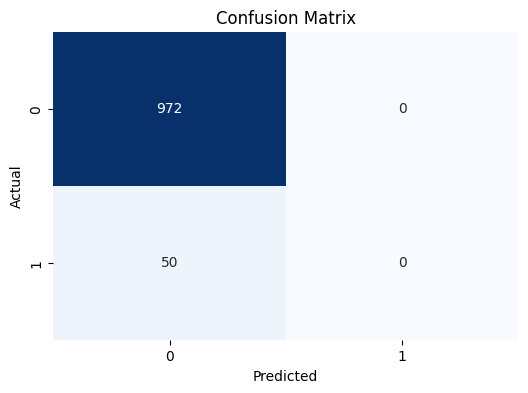

In [ ]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

In [ ]:
# Create an ensemble of TabPFN models
n_estimators = 3 # Number of models in the ensemble
ensemble_predictions = np.zeros((X_test.shape[0], 2)) # Initialize array to store predictions (for 2 classes)

for i in range(n_estimators):
    print(f"Training model {i+1}/{n_estimators}")
    # Initialize and train TabPFN with a different random state
    tabpfn_ensemble_model = TabPFNClassifier(device='cpu', random_state=i, ignore_pretraining_limits=True)

    # Fit the model (using limited data as before)
    tabpfn_ensemble_model.fit(X_train_limited.to_numpy().astype(np.float32), y_train_limited.to_numpy().astype(np.int64))

    # Get predictions and add to ensemble
    ensemble_predictions += tabpfn_ensemble_model.predict_proba(X_test.to_numpy().astype(np.float32))

# Average the predictions
ensemble_predictions /= n_estimators

# Get the final predicted class based on the average probability
y_pred_ensemble = np.argmax(ensemble_predictions, axis=1)

# Evaluate the ensemble model
accuracy_ensemble = accuracy_score(y_test, y_pred_ensemble)
roc_auc_ensemble = roc_auc_score(y_test, ensemble_predictions[:, 1]) # Use averaged probabilities for ROC AUC
f1_ensemble = f1_score(y_test, y_pred_ensemble)

print("\nEnsemble Model Evaluation:")
print(f"Accuracy on the test set: {accuracy_ensemble:.4f}")
print(f"ROC AUC on the test set: {roc_auc_ensemble:.4f}")
print(f"F1 Score on the test set: {f1_ensemble:.4f}")

Training model 1/3
Training model 2/3
Training model 3/3

Ensemble Model Evaluation:
Accuracy on the test set: 0.9511
ROC AUC on the test set: 0.8371
F1 Score on the test set: 0.0000


In [ ]:
print(data.columns)

Index(['id', 'gender', 'age', 'hypertension', 'heart_disease', 'ever_married',
       'work_type', 'Residence_type', 'avg_glucose_level', 'bmi',
       'smoking_status', 'stroke'],
      dtype='object')


In [ ]:
from tabpfn import TabPFNClassifier
from sklearn.model_selection import StratifiedKFold, GridSearchCV
from sklearn.metrics import accuracy_score, roc_auc_score, f1_score